In [ ]:
from huggingface_hub import login
from google.colab import userdata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score
import warnings
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
hf_token = userdata.get('huggingface')
login(hf_token)

In [ ]:
dataset_dim3 = load_dataset('Zlovoblachko/DeepSeek_dim3_balanced')

README.md:   0%|          | 0.00/798 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/90.1k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1392 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/174 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/175 [00:00<?, ? examples/s]

In [ ]:
train_df = pd.DataFrame(dataset_dim3['train'])
dev_df = pd.DataFrame(dataset_dim3['dev'])
test_df = pd.DataFrame(dataset_dim3['test'])

In [ ]:
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {dev_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nClass distribution in train:\n{train_df['Label'].value_counts()}")

Train shape: (1392, 8)
Validation shape: (174, 8)
Test shape: (175, 8)

Class distribution in train:
Label
H    480
0    480
L    432
Name: count, dtype: int64


In [ ]:
def combine_text_columns(df):
    text_columns = ['Previous clause', 'Previous clause label', 'Target clause', 'Target clause label',
                    'Number of the target clause in a sentence']
    combined = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
    return combined

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
X_train_text = combine_text_columns(train_df)
y_train = train_df['Label']
X_val_text = combine_text_columns(dev_df)
y_val = dev_df['Label']
X_test_text = combine_text_columns(test_df)
y_test = test_df['Label']

print(f"Sample combined text:\n{X_train_text.iloc[0][:200]}...")

Sample combined text:
('that is a waste of time', 'acl') Thesis ('because most people tend', 'advcl') Thesis 4...


In [ ]:
count_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95)

In [ ]:
X_train_count = count_vectorizer.fit_transform(X_train_text)
X_val_count = count_vectorizer.transform(X_val_text)
X_test_count = count_vectorizer.transform(X_test_text)

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

In [ ]:
print(f"CountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

CountVectorizer shape: (1392, 1197)
TF-IDF shape: (1392, 1197)


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,  # 5-fold cross-validation
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )
        # Fit on training data
        grid_search.fit(X_tr, y_train_encoded)
        # Best model from grid search
        best_model = grid_search.best_estimator_
        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_train_encoded,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.6094 (+/- 0.0196)
CV Accuracy: 0.6106 (+/- 0.0189)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV F1 Score: 0.7035 (+/- 0.0309)
CV Accuracy: 0.6997 (+/- 0.0324)

Training XGBoost...
Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
CV F1 Score: 0.7861 (+/- 0.0142)
CV Accuracy: 0.7830 (+/- 0.0148)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.6094 (+/- 0.0250)
CV Accuracy: 0.6099 (+/- 0.0255)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV F1 Score: 0.6677 (+/- 0.0146)
CV Accuracy: 0.6667 (+/- 0.0153)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators':

In [ ]:
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on validation set
    y_val_pred = res['best_model'].predict(res['X_val'])
    print(classification_report(y_val_encoded, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Predict on test set
    y_test_pred = res['best_model'].predict(res['X_test'])
    print(classification_report(y_test_encoded, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE

CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.5424    0.5333    0.5378        60
           1     0.5385    0.5833    0.5600        60
           2     0.6000    0.5556    0.5769        54

    accuracy                         0.5575       174
   macro avg     0.5603    0.5574    0.5582       174
weighted avg     0.5589    0.5575    0.5576       174

Cross-Validation Reliability:
  Accuracy: 0.6106 (std: 0.0189)
  F1-Score: 0.6094 (std: 0.0196)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9000    0.7500    0.8182        60
           1     0.5949    0.7833    0.6763        60
           2     0.6889    0.5741    0.6263        54

    accuracy                         0.7069       174
   macro avg     0.7279    0.7025


CountVectorizer:
------------------------------------------------------------


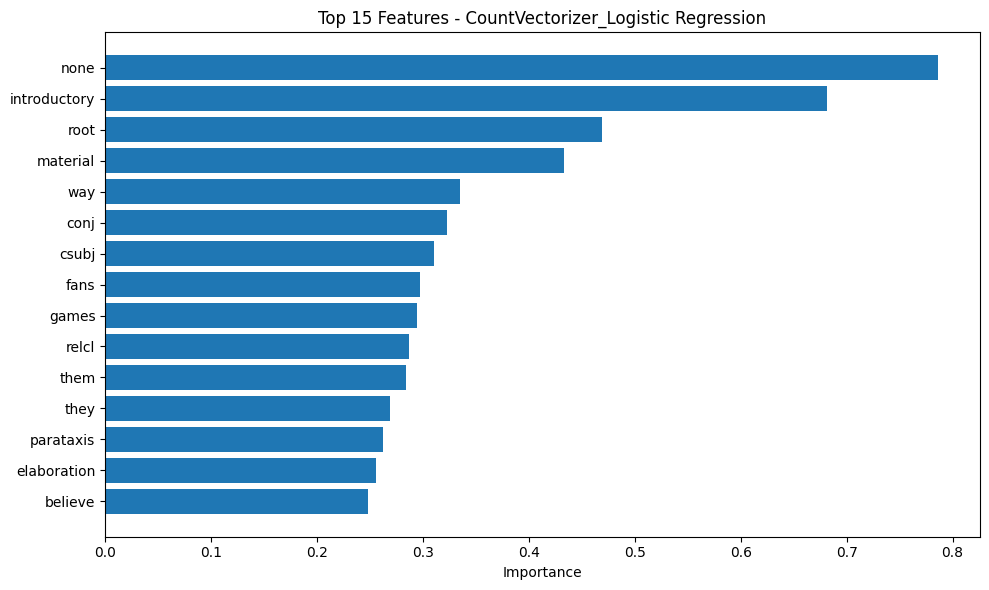


Logistic Regression - Top 10 features:
  relcl: 0.2865
  games: 0.2940
  fans: 0.2970
  csubj: 0.3106
  conj: 0.3223
  way: 0.3351
  material: 0.4331
  root: 0.4689
  introductory: 0.6815
  none: 0.7865


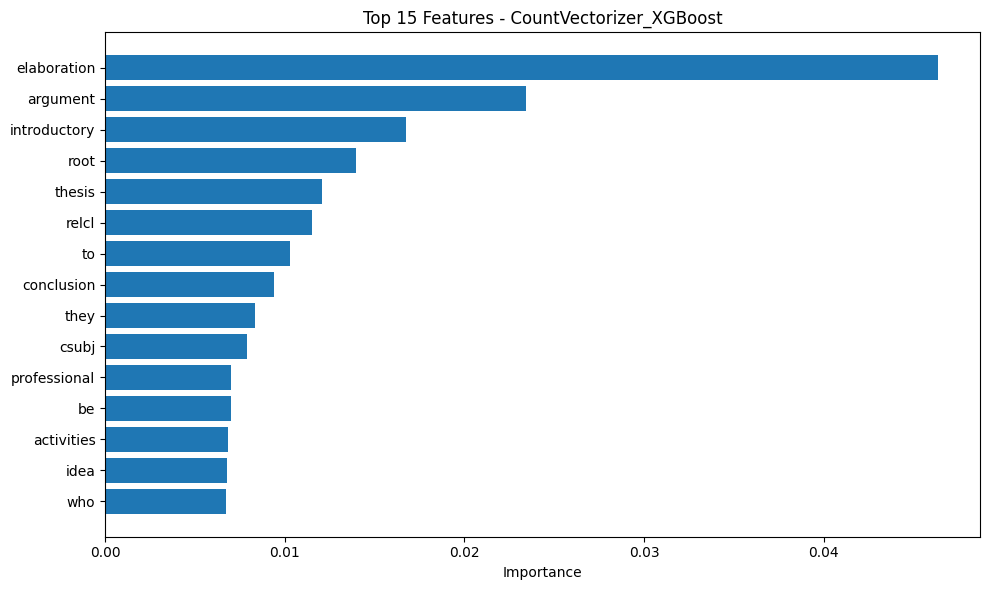


XGBoost - Top 10 features:
  csubj: 0.0079
  they: 0.0084
  conclusion: 0.0094
  to: 0.0103
  relcl: 0.0115
  thesis: 0.0121
  root: 0.0140
  introductory: 0.0167
  argument: 0.0234
  elaboration: 0.0464

TF-IDF:
------------------------------------------------------------


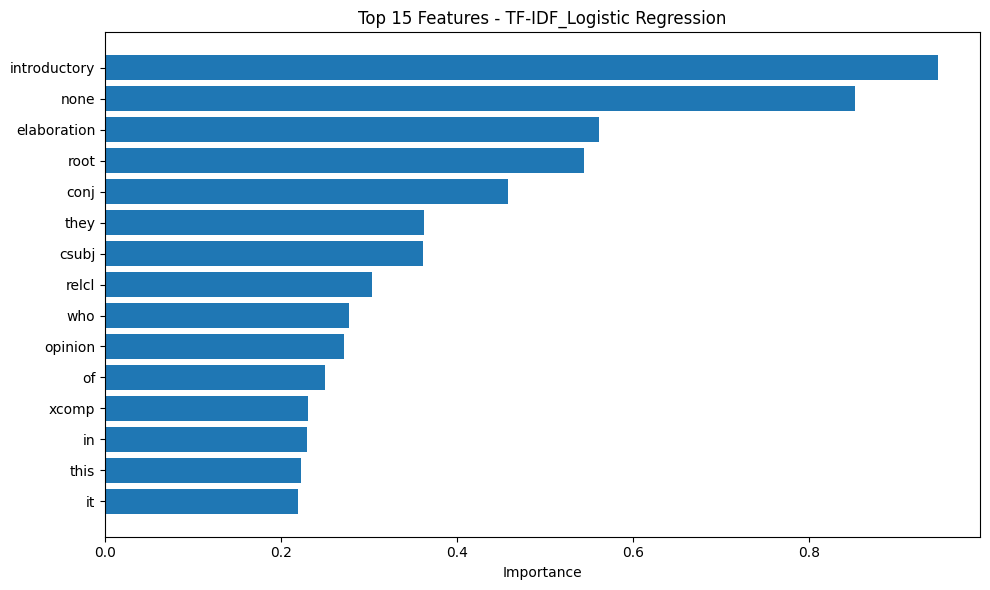


Logistic Regression - Top 10 features:
  opinion: 0.2721
  who: 0.2768
  relcl: 0.3032
  csubj: 0.3614
  they: 0.3628
  conj: 0.4575
  root: 0.5443
  elaboration: 0.5609
  none: 0.8528
  introductory: 0.9471


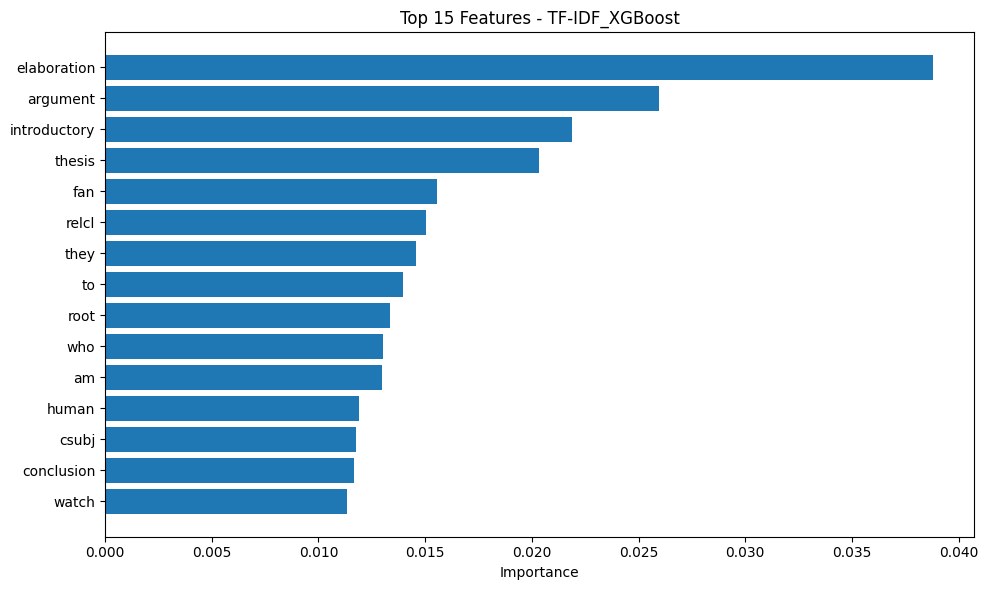


XGBoost - Top 10 features:
  who: 0.0130
  root: 0.0133
  to: 0.0140
  they: 0.0146
  relcl: 0.0150
  fan: 0.0155
  thesis: 0.0203
  introductory: 0.0219
  argument: 0.0259
  elaboration: 0.0388


In [ ]:
for vec_name, (X_tr, X_v, X_te) in vectorizers.items():
    vectorizer = count_vectorizer if vec_name == 'CountVectorizer' else tfidf_vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):  # Logistic Regression
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):  # Tree-based models
            importance = model.feature_importances_
        else:
            continue

        # Top 15 features
        top_indices = np.argsort(importance)[-15:]
        top_features = feature_names[top_indices]
        top_importance = importance[top_indices]

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(top_features)), top_importance)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Importance')
        plt.title(f'Top 15 Features - {key}')
        plt.tight_layout()
        plt.show()

        print(f"\n{model_name} - Top 10 features:")
        for feat, imp in zip(top_features[-10:], top_importance[-10:]):
            print(f"  {feat}: {imp:.4f}")

In [ ]:
summary_data = []

for key, res in results.items():
    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_val_encoded, y_val_pred),
        'Val_F1': f1_score(y_val_encoded, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_test_encoded, y_test_pred),
        'Test_F1': f1_score(y_test_encoded, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.6106           0.0189      0.6094     0.0196        0.5575  0.5576         0.6171   0.6160
      CountVectorizer_Decision Tree            0.6997           0.0324      0.7035     0.0309        0.7069  0.7097         0.7200   0.7233
            CountVectorizer_XGBoost            0.7830           0.0148      0.7861     0.0142        0.7529  0.7575         0.7486   0.7533
         TF-IDF_Logistic Regression            0.6099           0.0255      0.6094     0.0250        0.5345  0.5322         0.6400   0.6390
               TF-IDF_Decision Tree            0.6667           0.0153      0.6677     0.0146        0.6954  0.6939         0.6629   0.6649
                     TF-IDF_XGBoost            0.7636           0.0187      0.7655     0.0175        0.7299  0.7315         0.7314   0

Add preprocessing

In [ ]:
def preprocess_text(text):
    """Tokenize, lowercase, and lemmatize text using spaCy"""
    if pd.isna(text) or text == '':
        return ''

    # Process text with spaCy
    doc = nlp(text.lower())

    # Lemmatize and keep only alphabetic tokens
    lemmatized = [token.lemma_ for token in doc if token.is_alpha or token.is_digit]

    return ' '.join(lemmatized)

In [ ]:
text_columns = ['Previous clause', 'Previous clause label', 'Target clause', 'Target clause label']

print("Preprocessing training data...")
for col in text_columns:
    train_df[col] = train_df[col].astype(str).apply(preprocess_text)

print("Preprocessing validation data...")
for col in text_columns:
    dev_df[col] = dev_df[col].astype(str).apply(preprocess_text)

print("Preprocessing test data...")
for col in text_columns:
    test_df[col] = test_df[col].astype(str).apply(preprocess_text)

print("\nSample preprocessed text:")
print(f"{train_df['Previous clause'].iloc[0][:200]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Sample preprocessed text:
that be a waste of time acl...


In [ ]:
text_columns = ['Previous clause', 'Previous clause label', 'Target clause', 'Target clause label',
                    'Number of the target clause in a sentence']

In [ ]:
X_train = train_df[text_columns]
X_val = dev_df[text_columns]
X_test = test_df[text_columns]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1392, 5)
X_val shape: (174, 5)
X_test shape: (175, 5)


In [ ]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Define picklable reshape function
def reshape_to_2d(x):
    """Reshape 1D array to 2D for StandardScaler"""
    return np.array(x).reshape(-1, 1)

count_transformer = ColumnTransformer(
    transformers=[
        ('prev_clause', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Previous clause'),
        ('prev_clause_label', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Previous clause label'),
        ('target_clause', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target clause'),
        ('target_clause_label', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target clause label'),
        ('num', Pipeline([
            ('reshape', FunctionTransformer(reshape_to_2d)),
            ('scaler', StandardScaler())
        ]), 'Number of the target clause in a sentence')
    ],
    remainder='drop',
    sparse_threshold=0.0
)

In [ ]:
tfidf_transformer = ColumnTransformer(
    transformers=[
        ('prev_clause', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Previous clause'),
        ('prev_clause_label', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Previous clause label'),
        ('target_clause', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target clause'),
        ('target_clause_label', CountVectorizer(max_features=1250, min_df=2, max_df=0.95), 'Target clause label'),
        ('num', Pipeline([
            ('reshape', FunctionTransformer(reshape_to_2d)),
            ('scaler', StandardScaler())
        ]), 'Number of the target clause in a sentence')
    ],
    remainder='drop',
    sparse_threshold=1.0
)

In [ ]:
print("Fitting CountVectorizer...")
X_train_count = count_transformer.fit_transform(X_train)
X_val_count = count_transformer.transform(X_val)
X_test_count = count_transformer.transform(X_test)

print("Fitting TF-IDF...")
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_val_tfidf = tfidf_transformer.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test)

print(f"\nCountVectorizer shape: {X_train_count.shape}")
print(f"TF-IDF shape: {X_train_tfidf.shape}")

Fitting CountVectorizer...
Fitting TF-IDF...

CountVectorizer shape: (1392, 1158)
TF-IDF shape: (1392, 1158)


In [ ]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

vectorizers = {
    'CountVectorizer': (X_train_count, X_val_count, X_test_count, count_transformer),
    'TF-IDF': (X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_transformer)
}

In [ ]:
results = {}

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Vectorizer: {vec_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{vec_name}_{model_name}"
        results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'transformer': transformer
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Vectorizer: CountVectorizer

Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8311 (+/- 0.0143)
CV Accuracy: 0.8326 (+/- 0.0147)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV F1 Score: 0.8211 (+/- 0.0126)
CV Accuracy: 0.8226 (+/- 0.0122)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV F1 Score: 0.8729 (+/- 0.0247)
CV Accuracy: 0.8743 (+/- 0.0247)

Vectorizer: TF-IDF

Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8311 (+/- 0.0143)
CV Accuracy: 0.8326 (+/- 0.0147)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV F1 Score: 0.8211 (+/- 0.0126)
CV Accuracy: 0.8226 (+/- 0.0122)

Training XGBoost...
Best parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 

In [ ]:
for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for key, res in results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


CountVectorizer_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8636    0.9500    0.9048        60
           H     0.7797    0.7667    0.7731        60
           L     0.7755    0.7037    0.7379        54

    accuracy                         0.8103       174
   macro avg     0.8063    0.8068    0.8052       174
weighted avg     0.8073    0.8103    0.8076       174

Cross-Validation Reliability:
  Accuracy: 0.8326 (std: 0.0147)
  F1-Score: 0.8311 (std: 0.0143)

CountVectorizer_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9344    0.9500    0.9421        60
           H     0.7324    0.8667    0.7939        60
           L     0.7857    0.6111    0.6875        54

    accuracy                         0.8161       174
   macro avg     0.8175    0.8093    0.8078       174
weighte

In [ ]:
from sklearn.metrics import f1_score as f1_metric

print("\n" + "="*80)
print("COLUMN IMPORTANCE ANALYSIS")
print("="*80)
print("\nMeasuring importance by column ablation (removing each column):\n")

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Baseline performance on validation set
        y_v = y_val_encoded if results[key]['is_xgboost'] else y_val
        baseline_pred = model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        print(f"\n{model_name}:")
        print(f"  Baseline F1 (all columns): {baseline_f1:.4f}")

        # Test importance by removing each column
        column_importance = {}
        for i, col in enumerate(text_columns):
            # Create data with one column removed
            X_val_ablated = X_val.copy()

            # Set to empty string for text columns, 0 for numeric columns
            if col == 'Number of the target clause in a sentence':
                X_val_ablated[col] = 0  # Use 0 for numeric column
            else:
                X_val_ablated[col] = ''  # Use empty string for text columns

            # Transform and predict
            X_v_ablated = transformer.transform(X_val_ablated)
            ablated_pred = model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

            print(f"  {col}: {importance:.4f} (F1 without: {ablated_f1:.4f})")


COLUMN IMPORTANCE ANALYSIS

Measuring importance by column ablation (removing each column):


CountVectorizer:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.8076
  Previous clause: 0.0912 (F1 without: 0.7164)
  Previous clause label: -0.0045 (F1 without: 0.8121)
  Target clause: 0.0704 (F1 without: 0.7372)
  Target clause label: -0.0037 (F1 without: 0.8113)
  Number of the target clause in a sentence: 0.5259 (F1 without: 0.2817)

XGBoost:
  Baseline F1 (all columns): 0.8475
  Previous clause: 0.0967 (F1 without: 0.7508)
  Previous clause label: 0.0072 (F1 without: 0.8404)
  Target clause: 0.0681 (F1 without: 0.7794)
  Target clause label: 0.0072 (F1 without: 0.8404)
  Number of the target clause in a sentence: 0.4559 (F1 without: 0.3916)

TF-IDF:
------------------------------------------------------------

Logistic Regression:
  Baseline F1 (all columns): 0.8076
  Previous clause: 0.0912 (F1 without: 0.7164)
  Previo


COLUMN IMPORTANCE VISUALIZATION


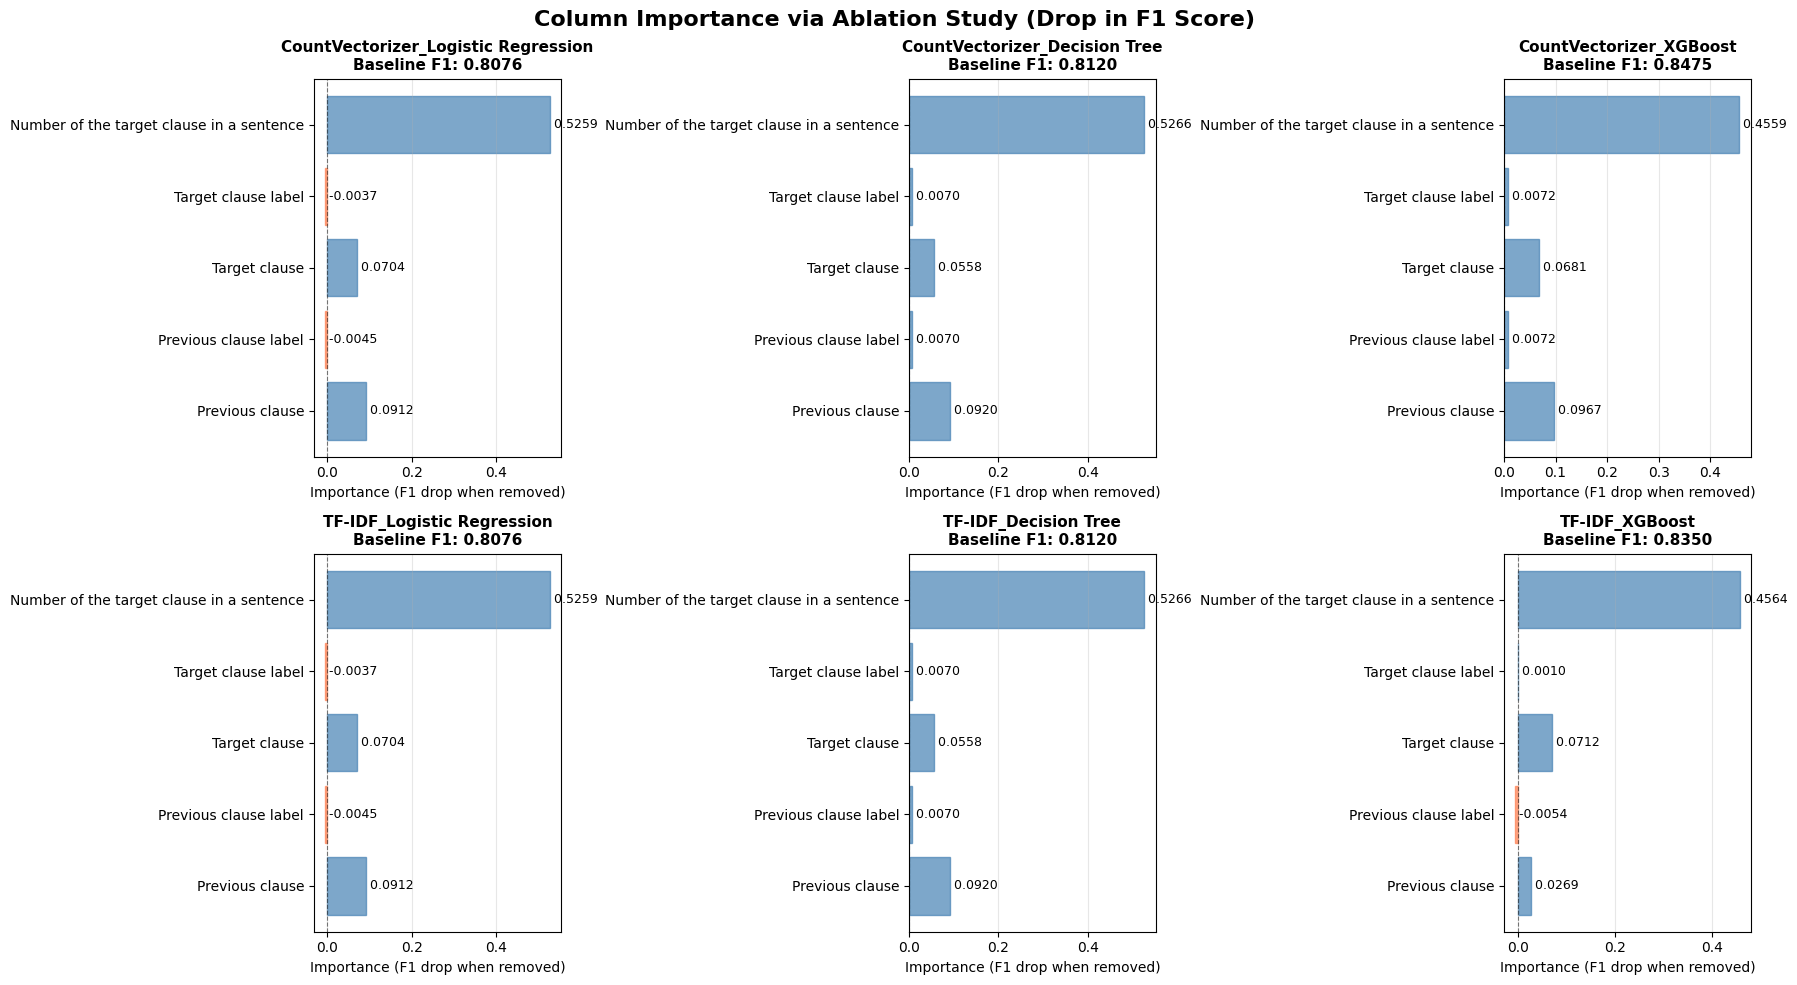


AVERAGE COLUMN IMPORTANCE ACROSS ALL MODELS


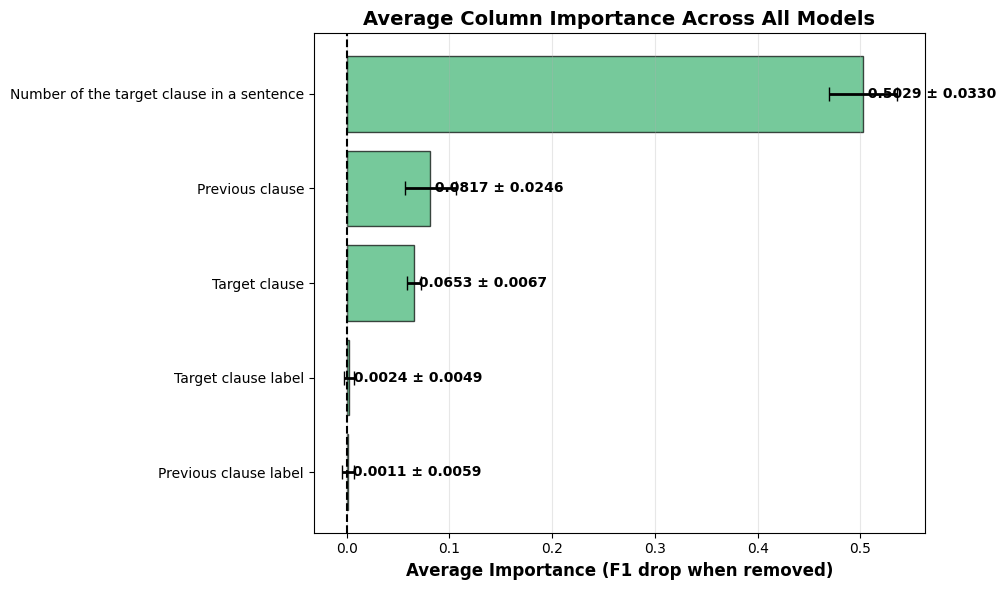


Column Importance Summary:
------------------------------------------------------------
Previous clause label         :  0.0011 ± 0.0059
Target clause label           :  0.0024 ± 0.0049
Target clause                 :  0.0653 ± 0.0067
Previous clause               :  0.0817 ± 0.0246
Number of the target clause in a sentence:  0.5029 ± 0.0330


In [ ]:
print("\n" + "="*80)
print("COLUMN IMPORTANCE VISUALIZATION")
print("="*80)

# Collect all ablation results
ablation_results = {}

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    for model_name in ['Logistic Regression', 'Decision Tree', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Baseline performance on validation set
        y_v = y_val_encoded if results[key]['is_xgboost'] else y_val
        baseline_pred = model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        # Test importance by removing each column
        column_importance = {}
        for col in text_columns:
            # Create data with one column removed
            X_val_ablated = X_val.copy()
            if col == 'Number of the target clause in a sentence':
                X_val_ablated[col] = 0  # Use 0 for numeric column
            else:
                X_val_ablated[col] = ''

            # Transform and predict
            X_v_ablated = transformer.transform(X_val_ablated)
            ablated_pred = model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

        ablation_results[key] = {
            'baseline': baseline_f1,
            'importance': column_importance
        }

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Column Importance via Ablation Study (Drop in F1 Score)', fontsize=16, fontweight='bold')

plot_idx = 0
for vec_name in ['CountVectorizer', 'TF-IDF']:
    for model_name in ['Logistic Regression', 'Decision Tree', 'XGBoost']:
        key = f"{vec_name}_{model_name}"

        ax = axes[plot_idx // 3, plot_idx % 3]

        importance_dict = ablation_results[key]['importance']
        columns = list(importance_dict.keys())
        importance_values = list(importance_dict.values())

        # Create bar plot
        bars = ax.barh(columns, importance_values, color='steelblue', alpha=0.7, edgecolor='black')

        # Color bars: positive (important) in blue, negative (harmful) in red
        for bar, val in zip(bars, importance_values):
            if val < 0:
                bar.set_color('coral')
            else:
                bar.set_color('steelblue')

        # Add value labels
        for i, (col, val) in enumerate(zip(columns, importance_values)):
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=9)

        # Formatting
        ax.set_xlabel('Importance (F1 drop when removed)', fontsize=10)
        ax.set_title(f'{key}\nBaseline F1: {ablation_results[key]["baseline"]:.4f}',
                     fontsize=11, fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.grid(axis='x', alpha=0.3)

        plot_idx += 1

plt.tight_layout()
plt.show()

# Summary plot: average importance across all models
print("\n" + "="*80)
print("AVERAGE COLUMN IMPORTANCE ACROSS ALL MODELS")
print("="*80)

avg_importance = {col: [] for col in text_columns}
for key, data in ablation_results.items():
    for col, imp in data['importance'].items():
        avg_importance[col].append(imp)

avg_importance_mean = {col: np.mean(vals) for col, vals in avg_importance.items()}
avg_importance_std = {col: np.std(vals) for col, vals in avg_importance.items()}

# Sort by mean importance
sorted_cols = sorted(avg_importance_mean.keys(), key=lambda x: avg_importance_mean[x])
sorted_means = [avg_importance_mean[col] for col in sorted_cols]
sorted_stds = [avg_importance_std[col] for col in sorted_cols]

# Create summary plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(sorted_cols, sorted_means, xerr=sorted_stds,
               color='mediumseagreen', alpha=0.7, edgecolor='black',
               capsize=5, error_kw={'linewidth': 2})

# Add value labels
for i, (col, mean, std) in enumerate(zip(sorted_cols, sorted_means, sorted_stds)):
    ax.text(mean, i, f' {mean:.4f} ± {std:.4f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Average Importance (F1 drop when removed)', fontsize=12, fontweight='bold')
ax.set_title('Average Column Importance Across All Models', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nColumn Importance Summary:")
print("-" * 60)
for col in sorted_cols:
    print(f"{col:30s}: {avg_importance_mean[col]:7.4f} ± {avg_importance_std[col]:.4f}")

In [ ]:
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("TOP FEATURES PER COLUMN")
print("="*80)

for vec_name, (X_tr, X_v, X_te, transformer) in vectorizers.items():
    print(f"\n{vec_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{vec_name}_{model_name}"
        model = results[key]['best_model']

        # Extract feature importance
        if hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue

        print(f"\n{model_name} - Top features per column:")

        # Get feature names for each column transformer
        feature_start = 0
        for col_name, vectorizer, col in transformer.transformers_:
            # Skip numeric column (StandardScaler pipeline)
            if col == 'Number of the target clause in a sentence':
                n_features = 1  # Numeric column contributes 1 feature
                col_importance = importance[feature_start:feature_start + n_features]
                print(f"\n  {col}:")
                print(f"    numeric_feature: {col_importance[0]:.4f}")
                feature_start += n_features
                continue

            # For text columns with CountVectorizer/TfidfVectorizer
            n_features = len(vectorizer.get_feature_names_out())
            col_importance = importance[feature_start:feature_start + n_features]
            col_features = vectorizer.get_feature_names_out()

            # Top 5 features for this column
            top_indices = np.argsort(col_importance)[-5:]
            top_features = col_features[top_indices]
            top_values = col_importance[top_indices]

            print(f"\n  {col}:")
            for feat, val in zip(reversed(top_features), reversed(top_values)):
                print(f"    {feat}: {val:.4f}")

            feature_start += n_features


TOP FEATURES PER COLUMN

CountVectorizer:
------------------------------------------------------------

Logistic Regression - Top features per column:

  Previous clause:
    root: 0.8334
    watch: 0.3970
    csubj: 0.3755
    ccomp: 0.3540
    there: 0.2937

  Previous clause label:
    introductory: 0.7663
    elaboration: 0.4515
    argument: 0.2266
    none: 0.2081
    conclusion: 0.1653

  Target clause:
    root: 0.6109
    they: 0.4865
    conj: 0.4313
    and: 0.2781
    he: 0.2552

  Target clause label:
    introductory: 0.7712
    elaboration: 0.3683
    material: 0.1442
    thesis: 0.1424
    support: 0.1226

  Number of the target clause in a sentence:
    numeric_feature: 1.7152

XGBoost - Top features per column:

  Previous clause:
    root: 0.0225
    when: 0.0214
    your: 0.0079
    become: 0.0071
    secondly: 0.0070

  Previous clause label:
    introductory: 0.0206
    elaboration: 0.0086
    material: 0.0069
    conclusion: 0.0062
    argument: 0.0032

  Target

In [ ]:
summary_data = []

for key, res in results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)
print(summary_df.to_string(index=False))


SUMMARY COMPARISON TABLE
                      Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
CountVectorizer_Logistic Regression            0.8326           0.0147      0.8311     0.0143        0.8103  0.8076         0.8286   0.8269
      CountVectorizer_Decision Tree            0.8226           0.0122      0.8211     0.0126        0.8161  0.8120         0.8000   0.7989
            CountVectorizer_XGBoost            0.8743           0.0247      0.8729     0.0247        0.8506  0.8475         0.8857   0.8846
         TF-IDF_Logistic Regression            0.8326           0.0147      0.8311     0.0143        0.8103  0.8076         0.8286   0.8269
               TF-IDF_Decision Tree            0.8226           0.0122      0.8211     0.0126        0.8161  0.8120         0.8000   0.7989
                     TF-IDF_XGBoost            0.8685           0.0207      0.8674     0.0207        0.8391  0.8350         0.8229   0

In [ ]:
import pickle
import json
from datetime import datetime

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None

for key, res in results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res

print("="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Prepare the complete pipeline components
model_package = {
    'model': best_config['best_model'],
    'transformer': best_config['transformer'],
    'label_encoder': label_encoder,
    'text_columns': text_columns,
    'is_xgboost': best_config['is_xgboost'],
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': {
        'test_f1': best_f1,
        'test_accuracy': accuracy_score(
            y_test_encoded if best_config['is_xgboost'] else y_test,
            best_config['best_model'].predict(best_config['X_test'])
        ),
        'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
        'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
        'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
        'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
    },
    'preprocessing_info': {
        'tokenization': 'spacy en_core_web_sm',
        'lowercasing': True,
        'lemmatization': True
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save the model package
model_filename = f'best_model_{best_key.replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, transformer, label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_model_{best_key.replace(" ", "_")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

BEST MODEL SELECTION

Best configuration: CountVectorizer_XGBoost
Test F1 Score: 0.8846
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Model saved to: best_model_CountVectorizer_XGBoost.pkl
Package includes: model, transformer, label encoder, and metadata
Metadata saved to: best_model_CountVectorizer_XGBoost_metadata.json


In [ ]:
# Cell 14: Create a reusable prediction function and save it
def create_predictor(model_package):
    """
    Create a prediction function from the saved model package.
    This function can be used in a separate pipeline.
    """
    import spacy
    import pandas as pd

    # Load spacy if not already loaded
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def preprocess_text(text):
        """Tokenize, lowercase, and lemmatize text"""
        if pd.isna(text) or text == '':
            return ''
        doc = nlp(text.lower())
        lemmatized = [token.lemma_ for token in doc if token.is_alpha or token.is_digit]
        return ' '.join(lemmatized)

    def predict(data):
        """
        Predict labels for new data.

        Parameters:
        -----------
        data : dict or pd.DataFrame
            Must contain keys/columns: 'Thesis', 'Target sentence segment',
            'Last argument', 'Target sentence'

        Returns:
        --------
        predictions : array
            Predicted labels in original format ('H' or 'L')
        probabilities : array (if available)
            Prediction probabilities
        """
        # Convert to DataFrame if dict
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Preprocess text columns
        for col in model_package['text_columns'][:-1]:
            df[col] = df[col].apply(preprocess_text)

        # Transform using saved transformer
        X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

# Test the predictor with a sample
predictor = create_predictor(model_package)

# Test with first row from test set
test_sample = test_df[text_columns].iloc[0:1].copy()
# Reset to original (non-preprocessed) text for realistic test
# In real usage, you'd have raw text, so we simulate that here
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)
print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Label'].iloc[0]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")


TESTING SAVED MODEL

Test sample shape: (1, 5)

Prediction: 0
True label: 0
Probabilities: [9.9221742e-01 5.3489674e-04 7.2476547e-03]

✓ Model package is working correctly!


In [ ]:
# Cell 15: Save the predictor function as a standalone module
predictor_code = '''"""
Standalone predictor for the trained text classification model.
Load this module and use predict() function for inference.

Usage:
------
import pickle
from predictor import load_model_and_predict

# Load model
with open('best_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Make predictions
data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """
    Predict labels for new data using the saved model package.

    Parameters:
    -----------
    model_package : dict
        The loaded model package from pickle file
    data : dict or pd.DataFrame
        Must contain keys/columns: 'Thesis', 'Target sentence segment',
        'Last argument', 'Target sentence'

    Returns:
    --------
    predictions : array
        Predicted labels in original format ('H' or 'L')
    probabilities : array or None
        Prediction probabilities (if available)
    """
    # Load spacy
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    # Convert to DataFrame if dict
    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Preprocess text columns
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    # Transform using saved transformer
    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    # Decode if XGBoost
    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    # Get probabilities if available
    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

# Save predictor as a Python module
with open('predictor.py', 'w') as f:
    f.write(predictor_code)

print("="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print("\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. predictor.py - Standalone prediction module")
print("\nTo use in a new pipeline:")
print("  import pickle")
print("  from predictor import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")

PREDICTOR MODULE SAVED

Saved files:
  1. best_model_CountVectorizer_XGBoost.pkl - Complete model package
  2. best_model_CountVectorizer_XGBoost_metadata.json - Model metadata (JSON)
  3. predictor.py - Standalone prediction module

To use in a new pipeline:
  import pickle
  from predictor import load_model_and_predict
  
  with open('best_model_CountVectorizer_XGBoost.pkl', 'rb') as f:
      model_package = pickle.load(f)
  
  predictions, probs = load_model_and_predict(model_package, your_data)


## Embedding models

In [ ]:
!pip install sentence-transformers torch transformers

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.preprocessing import normalize

In [ ]:
embedding_models = {
    'e5-base-v2': 'intfloat/e5-base-v2',
    'bge-small-en-v1.5': 'BAAI/bge-small-en-v1.5',
    'llama-small': 'meta-llama/Llama-3.2-1B'
}

def get_e5_embeddings(texts, model_name='intfloat/e5-base-v2'):
    """Get embeddings from E5 model"""
    model = SentenceTransformer(model_name)
    # E5 models require "query: " prefix for queries
    texts_with_prefix = [f"query: {text}" for text in texts]
    embeddings = model.encode(texts_with_prefix, show_progress_bar=True, batch_size=32)
    return embeddings

def get_bge_embeddings(texts, model_name='BAAI/bge-small-en-v1.5'):
    """Get embeddings from BGE model"""
    model = SentenceTransformer(model_name)
    # BGE models benefit from instruction prefix
    instruction = "Represent this sentence for classification: "
    texts_with_instruction = [instruction + text for text in texts]
    embeddings = model.encode(texts_with_instruction, show_progress_bar=True, batch_size=32)
    return embeddings

def get_llama_embeddings(texts, model_name='meta-llama/Llama-3.2-1B'):
    """Get embeddings from Llama model using mean pooling"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.eval()
    embeddings = []
    batch_size = 8  # Smaller batch for larger model

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**encoded)
            # Mean pooling
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")

    return np.vstack(embeddings)

print("Embedding functions defined")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Embedding functions defined
Using device: cuda


In [ ]:
text_columns = ['Previous clause', 'Previous clause label', 'Target clause', 'Target clause label',
                    'Number of the target clause in a sentence']

In [ ]:
X_train_raw = train_df[text_columns]
X_val_raw = dev_df[text_columns]
X_test_raw = test_df[text_columns]

print(f"X_train_raw shape: {X_train_raw.shape}")
print(f"X_val_raw shape: {X_val_raw.shape}")
print(f"X_test_raw shape: {X_test_raw.shape}")

X_train_raw shape: (1392, 5)
X_val_raw shape: (174, 5)
X_test_raw shape: (175, 5)


In [ ]:
print("\n" + "="*80)
print("GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_e5 = SentenceTransformer('intfloat/e5-base-v2')

# Generate embeddings for each column separately
X_train_e5_cols = []
X_val_e5_cols = []
X_test_e5_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_train = model_e5.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_e5_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_val = model_e5.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_e5_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').apply(lambda x: f"query: {x}").tolist()
    emb_test = model_e5.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_e5_cols.append(emb_test)

# Concatenate all column embeddings
X_train_e5 = np.hstack(X_train_e5_cols)
X_val_e5 = np.hstack(X_val_e5_cols)
X_test_e5 = np.hstack(X_test_e5_cols)

print(f"\nE5 embeddings shape: {X_train_e5.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_e5_cols[0].shape[1]} dimensions)")


GENERATING E5-BASE-V2 EMBEDDINGS (PER COLUMN)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


Processing column: Previous clause
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Previous clause label
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Target clause
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Target clause label
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Number of the target clause in a sentence
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


E5 embeddings shape: (1392, 3840)
(Each of 5 columns contributes 768 dimensions)


In [ ]:
# Cell 21: Generate embeddings for BGE-small-en-v1.5 using ColumnTransformer approach
print("\n" + "="*80)
print("GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)")
print("="*80)

model_bge = SentenceTransformer('BAAI/bge-small-en-v1.5')
instruction = "Represent this sentence for classification: "

# Generate embeddings for each column separately
X_train_bge_cols = []
X_val_bge_cols = []
X_test_bge_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').astype(str).apply(lambda x: instruction + x).tolist()
    emb_train = model_bge.encode(texts_train, show_progress_bar=True, batch_size=32)
    X_train_bge_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').astype(str).apply(lambda x: instruction + x).tolist()
    emb_val = model_bge.encode(texts_val, show_progress_bar=True, batch_size=32)
    X_val_bge_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').astype(str).apply(lambda x: instruction + x).tolist()
    emb_test = model_bge.encode(texts_test, show_progress_bar=True, batch_size=32)
    X_test_bge_cols.append(emb_test)

# Concatenate all column embeddings
X_train_bge = np.hstack(X_train_bge_cols)
X_val_bge = np.hstack(X_val_bge_cols)
X_test_bge = np.hstack(X_test_bge_cols)

print(f"\nBGE embeddings shape: {X_train_bge.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_bge_cols[0].shape[1]} dimensions)")


GENERATING BGE-SMALL-EN-V1.5 EMBEDDINGS (PER COLUMN)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Processing column: Previous clause
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Previous clause label
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Target clause
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Target clause label
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


Processing column: Number of the target clause in a sentence
  Training set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

  Validation set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  Test set...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]


BGE embeddings shape: (1392, 1920)
(Each of 5 columns contributes 384 dimensions)


In [ ]:
# Cell 22: Generate embeddings for Llama using ColumnTransformer approach (OPTIONAL)
print("\n" + "="*80)
print("GENERATING LLAMA EMBEDDINGS (PER COLUMN)")
print("="*80)
print("WARNING: This may take a while and requires significant memory")
tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
model_llama = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_llama = model_llama.to(device)
model_llama.eval()

def get_llama_embeddings_batch(texts, batch_size=8):
   """Helper function for batched Llama embeddings"""
   embeddings = []
   for i in range(0, len(texts), batch_size):
       batch_texts = texts[i:i+batch_size]
       encoded = tokenizer(batch_texts, padding=True, truncation=True,
                          max_length=512, return_tensors='pt')
       encoded = {k: v.to(device) for k, v in encoded.items()}
       with torch.no_grad():
           outputs = model_llama(**encoded)
           attention_mask = encoded['attention_mask']
           token_embeddings = outputs.last_hidden_state
           input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
           sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
           sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
           batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
           embeddings.append(batch_embeddings)

       if (i // batch_size + 1) % 10 == 0:
           print(f"    Processed {i + len(batch_texts)}/{len(texts)} texts")

   return np.vstack(embeddings)

X_train_llama_cols = []
X_val_llama_cols = []
X_test_llama_cols = []

for col in text_columns:
    print(f"\nProcessing column: {col}")

    # Training set
    print("  Training set...")
    texts_train = X_train_raw[col].fillna('').astype(str).tolist()
    emb_train = get_llama_embeddings_batch(texts_train)
    X_train_llama_cols.append(emb_train)

    # Validation set
    print("  Validation set...")
    texts_val = X_val_raw[col].fillna('').astype(str).tolist()
    emb_val = get_llama_embeddings_batch(texts_val)
    X_val_llama_cols.append(emb_val)

    # Test set
    print("  Test set...")
    texts_test = X_test_raw[col].fillna('').astype(str).tolist()
    emb_test = get_llama_embeddings_batch(texts_test)
    X_test_llama_cols.append(emb_test)

X_train_llama = np.hstack(X_train_llama_cols)
X_val_llama = np.hstack(X_val_llama_cols)
X_test_llama = np.hstack(X_test_llama_cols)

print(f"\nLlama embeddings shape: {X_train_llama.shape}")
print(f"(Each of {len(text_columns)} columns contributes {X_train_llama_cols[0].shape[1]} dimensions)")
llama_available = True


GENERATING LLAMA EMBEDDINGS (PER COLUMN)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]


Processing column: Previous clause
  Training set...
    Processed 80/1392 texts
    Processed 160/1392 texts
    Processed 240/1392 texts
    Processed 320/1392 texts
    Processed 400/1392 texts
    Processed 480/1392 texts
    Processed 560/1392 texts
    Processed 640/1392 texts
    Processed 720/1392 texts
    Processed 800/1392 texts
    Processed 880/1392 texts
    Processed 960/1392 texts
    Processed 1040/1392 texts
    Processed 1120/1392 texts
    Processed 1200/1392 texts
    Processed 1280/1392 texts
    Processed 1360/1392 texts
  Validation set...
    Processed 80/174 texts
    Processed 160/174 texts
  Test set...
    Processed 80/175 texts
    Processed 160/175 texts

Processing column: Previous clause label
  Training set...
    Processed 80/1392 texts
    Processed 160/1392 texts
    Processed 240/1392 texts
    Processed 320/1392 texts
    Processed 400/1392 texts
    Processed 480/1392 texts
    Processed 560/1392 texts
    Processed 640/1392 texts
    Processed 

In [ ]:
embedding_vectorizers = {
    'E5-base-v2': (X_train_e5, X_val_e5, X_test_e5),
    'BGE-small-en-v1.5': (X_train_bge, X_val_bge, X_test_bge)
}

if llama_available:
    embedding_vectorizers['Llama'] = (X_train_llama, X_val_llama, X_test_llama)

print(f"\nAvailable embeddings: {list(embedding_vectorizers.keys())}")


Available embeddings: ['E5-base-v2', 'BGE-small-en-v1.5', 'Llama']


In [ ]:
# Cell 7: Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100],
            'subsample': [0.8, 1.0]
        }
    }
}

In [ ]:
y_train = train_df['Label']
y_val = dev_df['Label']
y_test = test_df['Label']

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Cell 24: Train models with embeddings
embedding_results = {}

for emb_name, (X_tr, X_v, X_te) in embedding_vectorizers.items():
    print(f"\n{'='*60}")
    print(f"Embedding Model: {emb_name}")
    print(f"{'='*60}")

    for model_name, model_config in models.items():
        print(f"\nTraining {model_name}...")

        # Use encoded labels for XGBoost, original for others
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train

        # GridSearchCV with validation set scoring
        grid_search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0,
            return_train_score=True
        )

        # Fit on training data
        grid_search.fit(X_tr, y_tr)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Cross-validation scores for reliability
        cv_results = cross_validate(
            best_model, X_tr, y_tr,
            cv=5,
            scoring=['accuracy', 'f1_weighted'],
            return_train_score=True,
            n_jobs=-1
        )

        # Store results
        key = f"{emb_name}_{model_name}"
        embedding_results[key] = {
            'best_params': grid_search.best_params_,
            'best_model': best_model,
            'cv_scores': cv_results,
            'X_val': X_v,
            'X_test': X_te,
            'is_xgboost': model_name == 'XGBoost',
            'embedding_name': emb_name
        }

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"CV F1 Score: {cv_results['test_f1_weighted'].mean():.4f} (+/- {cv_results['test_f1_weighted'].std():.4f})")
        print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")


Embedding Model: E5-base-v2

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8672 (+/- 0.0243)
CV Accuracy: 0.8685 (+/- 0.0240)

Training Decision Tree...
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
CV F1 Score: 0.7338 (+/- 0.0175)
CV Accuracy: 0.7349 (+/- 0.0179)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
CV F1 Score: 0.8575 (+/- 0.0115)
CV Accuracy: 0.8599 (+/- 0.0110)

Embedding Model: BGE-small-en-v1.5

Training Logistic Regression...
Best parameters: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 Score: 0.8598 (+/- 0.0111)
CV Accuracy: 0.8606 (+/- 0.0106)

Training Decision Tree...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
CV F1 Score: 0.7312 (+/- 0.0204)
CV Accuracy: 0.7313 (+/- 0.0204)

Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 

In [ ]:
# Cell 25: Evaluate embedding-based models
print("\n" + "="*80)
print("VALIDATION SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_val_pred = res['best_model'].predict(res['X_val'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)
        print(classification_report(y_val, y_val_pred_decoded, digits=4))
    else:
        print(classification_report(y_val, y_val_pred, digits=4))

    # Cross-validation reliability statistics
    print(f"Cross-Validation Reliability:")
    print(f"  Accuracy: {res['cv_scores']['test_accuracy'].mean():.4f} (std: {res['cv_scores']['test_accuracy'].std():.4f})")
    print(f"  F1-Score: {res['cv_scores']['test_f1_weighted'].mean():.4f} (std: {res['cv_scores']['test_f1_weighted'].std():.4f})")

print("\n" + "="*80)
print("TEST SET PERFORMANCE (EMBEDDINGS)")
print("="*80)

for key, res in embedding_results.items():
    print(f"\n{key}")
    print("-" * 60)

    # Use encoded labels for XGBoost predictions
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])

    # Decode predictions for XGBoost to show original labels in report
    if res['is_xgboost']:
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)
        print(classification_report(y_test, y_test_pred_decoded, digits=4))
    else:
        print(classification_report(y_test, y_test_pred, digits=4))


VALIDATION SET PERFORMANCE (EMBEDDINGS)

E5-base-v2_Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9344    0.9500    0.9421        60
           H     0.8060    0.9000    0.8504        60
           L     0.8478    0.7222    0.7800        54

    accuracy                         0.8621       174
   macro avg     0.8627    0.8574    0.8575       174
weighted avg     0.8633    0.8621    0.8602       174

Cross-Validation Reliability:
  Accuracy: 0.8685 (std: 0.0240)
  F1-Score: 0.8672 (std: 0.0243)

E5-base-v2_Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8889    0.9333    0.9106        60
           H     0.7581    0.7833    0.7705        60
           L     0.7143    0.6481    0.6796        54

    accuracy                         0.7931       174
   macro avg     0.7871    0.7

In [ ]:
# Cell 26: Embedding results summary table
embedding_summary_data = []

for key, res in embedding_results.items():
    y_v = y_val_encoded if res['is_xgboost'] else y_val
    y_t = y_test_encoded if res['is_xgboost'] else y_test

    y_val_pred = res['best_model'].predict(res['X_val'])
    y_test_pred = res['best_model'].predict(res['X_test'])

    embedding_summary_data.append({
        'Configuration': key,
        'CV_Accuracy_Mean': res['cv_scores']['test_accuracy'].mean(),
        'CV_Accuracy_Std': res['cv_scores']['test_accuracy'].std(),
        'CV_F1_Mean': res['cv_scores']['test_f1_weighted'].mean(),
        'CV_F1_Std': res['cv_scores']['test_f1_weighted'].std(),
        'Val_Accuracy': accuracy_score(y_v, y_val_pred),
        'Val_F1': f1_score(y_v, y_val_pred, average='weighted'),
        'Test_Accuracy': accuracy_score(y_t, y_test_pred),
        'Test_F1': f1_score(y_t, y_test_pred, average='weighted')
    })

embedding_summary_df = pd.DataFrame(embedding_summary_data)
embedding_summary_df = embedding_summary_df.round(4)
print("\n" + "="*80)
print("EMBEDDING MODELS SUMMARY")
print("="*80)
print(embedding_summary_df.to_string(index=False))


EMBEDDING MODELS SUMMARY
                        Configuration  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std  Val_Accuracy  Val_F1  Test_Accuracy  Test_F1
       E5-base-v2_Logistic Regression            0.8685           0.0240      0.8672     0.0243        0.8621  0.8602         0.8514   0.8501
             E5-base-v2_Decision Tree            0.7349           0.0179      0.7338     0.0175        0.7931  0.7906         0.7829   0.7798
                   E5-base-v2_XGBoost            0.8599           0.0110      0.8575     0.0115        0.8391  0.8368         0.8171   0.8124
BGE-small-en-v1.5_Logistic Regression            0.8606           0.0106      0.8598     0.0111        0.8276  0.8256         0.8057   0.8029
      BGE-small-en-v1.5_Decision Tree            0.7313           0.0204      0.7312     0.0204        0.7586  0.7498         0.7086   0.7108
            BGE-small-en-v1.5_XGBoost            0.8534           0.0176      0.8510     0.0180        0.8333  0.8307     

In [ ]:
# Cell 22b: Column ablation analysis for embeddings (including Llama)
print("\n" + "="*80)
print("COLUMN IMPORTANCE ANALYSIS FOR EMBEDDINGS")
print("="*80)
print("\nMeasuring importance by column ablation (removing each column's embeddings):\n")

# Store column dimension info
e5_dim = X_train_e5_cols[0].shape[1]
bge_dim = X_train_bge_cols[0].shape[1]

embedding_ablation_results = {}

# Determine which embeddings to analyze
embeddings_to_analyze = ['E5-base-v2', 'BGE-small-en-v1.5']
if llama_available:
    embeddings_to_analyze.append('Llama-3.2-1B')
    llama_dim = X_train_llama_cols[0].shape[1]

for emb_name in embeddings_to_analyze:
    if emb_name == 'E5-base-v2':
        X_tr, X_v = X_train_e5, X_val_e5
        cols_list = X_train_e5_cols
        val_cols_list = X_val_e5_cols
        dim_per_col = e5_dim
    elif emb_name == 'BGE-small-en-v1.5':
        X_tr, X_v = X_train_bge, X_val_bge
        cols_list = X_train_bge_cols
        val_cols_list = X_val_bge_cols
        dim_per_col = bge_dim
    else:  # Llama
        X_tr, X_v = X_train_llama, X_val_llama
        cols_list = X_train_llama_cols
        val_cols_list = X_val_llama_cols
        dim_per_col = llama_dim

    print(f"\n{emb_name}:")
    print("-" * 60)

    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{emb_name}_{model_name}"

        # Train a fresh model for this analysis
        model_config = models[model_name]
        y_tr = y_train_encoded if model_name == 'XGBoost' else y_train
        y_v = y_val_encoded if model_name == 'XGBoost' else y_val

        # Train baseline model
        baseline_model = model_config['model']
        baseline_model.fit(X_tr, y_tr)
        baseline_pred = baseline_model.predict(X_v)
        baseline_f1 = f1_metric(y_v, baseline_pred, average='weighted')

        print(f"\n{model_name}:")
        print(f"  Baseline F1 (all columns): {baseline_f1:.4f}")

        # Test importance by removing each column's embeddings
        column_importance = {}
        for i, col in enumerate(text_columns):
            # Create ablated embeddings (all columns except current one)
            train_ablated_cols = [cols_list[j] for j in range(len(text_columns)) if j != i]
            val_ablated_cols = [val_cols_list[j] for j in range(len(text_columns)) if j != i]

            X_tr_ablated = np.hstack(train_ablated_cols)
            X_v_ablated = np.hstack(val_ablated_cols)

            # Train and predict with ablated data
            ablated_model = model_config['model']
            ablated_model.fit(X_tr_ablated, y_tr)
            ablated_pred = ablated_model.predict(X_v_ablated)
            ablated_f1 = f1_metric(y_v, ablated_pred, average='weighted')

            # Importance = drop in performance when column removed
            importance = baseline_f1 - ablated_f1
            column_importance[col] = importance

            print(f"  {col}: {importance:.4f} (F1 without: {ablated_f1:.4f})")

        embedding_ablation_results[key] = column_importance

# Visualize embedding column importance
num_embeddings = len(embeddings_to_analyze)
fig, axes = plt.subplots(1, num_embeddings, figsize=(6*num_embeddings, 6))
if num_embeddings == 1:
    axes = [axes]  # Make it iterable if only one subplot

fig.suptitle('Column Importance for Embedding Models (Ablation Study)', fontsize=16, fontweight='bold')

for idx, emb_name in enumerate(embeddings_to_analyze):
    ax = axes[idx]

    # Collect importance across models for this embedding
    importance_by_col = {col: [] for col in text_columns}
    for model_name in ['Logistic Regression', 'XGBoost']:
        key = f"{emb_name}_{model_name}"
        if key in embedding_ablation_results:
            for col, imp in embedding_ablation_results[key].items():
                importance_by_col[col].append(imp)

    # Calculate mean and std
    cols = list(importance_by_col.keys())
    means = [np.mean(importance_by_col[col]) for col in cols]
    stds = [np.std(importance_by_col[col]) for col in cols]

    # Sort by importance
    sorted_indices = np.argsort(means)
    cols_sorted = [cols[i] for i in sorted_indices]
    means_sorted = [means[i] for i in sorted_indices]
    stds_sorted = [stds[i] for i in sorted_indices]

    # Plot
    bars = ax.barh(cols_sorted, means_sorted, xerr=stds_sorted,
                   color='coral', alpha=0.7, edgecolor='black', capsize=5)

    # Color coding
    for bar, val in zip(bars, means_sorted):
        if val < 0:
            bar.set_color('lightcoral')
        else:
            bar.set_color('coral')

    # Add value labels
    for i, (col, mean, std) in enumerate(zip(cols_sorted, means_sorted, stds_sorted)):
        ax.text(mean, i, f' {mean:.4f}', va='center', fontsize=10)

    ax.set_xlabel('Importance (F1 drop when removed)', fontsize=11, fontweight='bold')
    ax.set_title(f'{emb_name}', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary: Average column importance across ALL embedding models
print("\n" + "="*80)
print("AVERAGE COLUMN IMPORTANCE ACROSS ALL EMBEDDING MODELS")
print("="*80)

overall_importance_by_col = {col: [] for col in text_columns}
for key, col_imp in embedding_ablation_results.items():
    for col, imp in col_imp.items():
        overall_importance_by_col[col].append(imp)

overall_means = {col: np.mean(vals) for col, vals in overall_importance_by_col.items()}
overall_stds = {col: np.std(vals) for col, vals in overall_importance_by_col.items()}

# Sort by importance
sorted_cols = sorted(overall_means.keys(), key=lambda x: overall_means[x])
sorted_means = [overall_means[col] for col in sorted_cols]
sorted_stds = [overall_stds[col] for col in sorted_cols]

# Create overall summary plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(sorted_cols, sorted_means, xerr=sorted_stds,
               color='mediumseagreen', alpha=0.7, edgecolor='black',
               capsize=5, error_kw={'linewidth': 2})

# Color bars
for bar, val in zip(bars, sorted_means):
    if val < 0:
        bar.set_color('lightcoral')
    else:
        bar.set_color('mediumseagreen')

# Add value labels
for i, (col, mean, std) in enumerate(zip(sorted_cols, sorted_means, sorted_stds)):
    ax.text(mean, i, f' {mean:.4f} ± {std:.4f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Average Importance (F1 drop when removed)', fontsize=12, fontweight='bold')
ax.set_title('Average Column Importance Across All Embedding Models', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nColumn Importance Summary (All Embedding Models):")
print("-" * 60)
for col in sorted_cols:
    print(f"{col:30s}: {overall_means[col]:7.4f} ± {overall_stds[col]:.4f}")

In [ ]:
# Cell 28: Identify and save the overall best model
import pickle
import json
from datetime import datetime

# Combine all results (traditional vectorizers + embeddings)
all_results = {**embedding_results}

# Find the best model based on test F1 score
best_config = None
best_f1 = 0
best_key = None
best_type = None  # 'traditional' or 'embedding'

print("="*80)
print("EVALUATING ALL MODELS")
print("="*80)

for key, res in all_results.items():
    y_t = y_test_encoded if res['is_xgboost'] else y_test
    y_test_pred = res['best_model'].predict(res['X_test'])
    test_f1 = f1_score(y_t, y_test_pred, average='weighted')
    test_acc = accuracy_score(y_t, y_test_pred)

    print(f"{key:50s} - Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_key = key
        best_config = res
        # Determine if it's traditional or embedding-based
        best_type = 'embedding' if 'embedding_name' in res else 'traditional'

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest configuration: {best_key}")
print(f"Model type: {best_type}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Best hyperparameters: {best_config['best_params']}")

# Calculate test accuracy for best model
y_t = y_test_encoded if best_config['is_xgboost'] else y_test
y_test_pred_best = best_config['best_model'].predict(best_config['X_test'])
test_accuracy = accuracy_score(y_t, y_test_pred_best)

# Prepare the complete pipeline components based on model type
# Embedding-based model
embedding_name = best_config['embedding_name']
model_package = {
        'model': best_config['best_model'],
        'label_encoder': label_encoder,
        'text_columns': text_columns,
        'is_xgboost': best_config['is_xgboost'],
        'config_name': best_key,
        'model_type': 'embedding',
        'embedding_name': embedding_name,
        'best_params': best_config['best_params'],
        'performance': {
            'test_f1': best_f1,
            'test_accuracy': test_accuracy,
            'cv_f1_mean': best_config['cv_scores']['test_f1_weighted'].mean(),
            'cv_f1_std': best_config['cv_scores']['test_f1_weighted'].std(),
            'cv_accuracy_mean': best_config['cv_scores']['test_accuracy'].mean(),
            'cv_accuracy_std': best_config['cv_scores']['test_accuracy'].std()
        },
        'preprocessing_info': {
            'preprocessing': 'none',
            'embedding_model': embedding_name,
            'per_column_embedding': True
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

# Save the model package
model_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved to: {model_filename}")
print(f"Package includes: model, {'transformer, ' if best_type == 'traditional' else ''}label encoder, and metadata")

# Save metadata separately as JSON for easy inspection
metadata = {
    'config_name': best_key,
    'model_type': best_type,
    'best_params': best_config['best_params'],
    'performance': model_package['performance'],
    'preprocessing_info': model_package['preprocessing_info'],
    'text_columns': text_columns,
    'timestamp': model_package['timestamp']
}

metadata_filename = f'best_overall_model_{best_key.replace(" ", "_").replace("/", "-")}_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to: {metadata_filename}")

In [ ]:
def create_embedding_predictor(model_package):
    """
    Create a prediction function for embedding-based models.
    """
    import pandas as pd
    import numpy as np
    import torch
    from sentence_transformers import SentenceTransformer
    from transformers import AutoTokenizer, AutoModel

    embedding_name = model_package['embedding_name']

    # Determine embedding model and configuration
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '
    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '
    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        # Load Llama model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        prefix = ''
    else:
        raise ValueError(f"Unknown embedding model: {embedding_name}")

    def get_llama_embeddings(texts, batch_size=8):
        """Generate Llama embeddings with mean pooling"""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True,
                               max_length=512, return_tensors='pt')
            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = emb_model(**encoded)
                attention_mask = encoded['attention_mask']
                token_embeddings = outputs.last_hidden_state
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
                sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
                embeddings.append(batch_embeddings)

        return np.vstack(embeddings)

    def predict(data):
        """Predict labels for new data"""
        if isinstance(data, dict):
            df = pd.DataFrame([data])
        else:
            df = data.copy()

        # Generate embeddings for each column
        embeddings_list = []
        for col in model_package['text_columns']:
            texts = df[col].fillna('').astype(str).tolist()

            if use_llama:
                col_embeddings = get_llama_embeddings(texts)
            else:
                texts_with_prefix = [prefix + text for text in texts]
                col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

            embeddings_list.append(col_embeddings)

        # Concatenate all column embeddings
        X_transformed = np.hstack(embeddings_list)

        # Predict
        predictions_encoded = model_package['model'].predict(X_transformed)

        # Decode if XGBoost
        if model_package['is_xgboost']:
            predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
        else:
            predictions = predictions_encoded

        # Get probabilities if available
        probabilities = None
        if hasattr(model_package['model'], 'predict_proba'):
            probabilities = model_package['model'].predict_proba(X_transformed)

        return predictions, probabilities

    return predict

predictor = create_embedding_predictor(model_package)

# Test the predictor with a sample
print("\n" + "="*80)
print("TESTING SAVED MODEL")
print("="*80)

# Use raw test data for realistic test
test_sample = test_df[text_columns].iloc[0:1].copy()

print("\nTest sample shape:", test_sample.shape)

predictions, probabilities = predictor(test_sample)

print(f"\nPrediction: {predictions[0]}")
print(f"True label: {test_df['Label'].iloc[0]}")
if probabilities is not None:
    print(f"Probabilities: {probabilities[0]}")

print("\n✓ Model package is working correctly!")

In [ ]:
# Cell 30: REPLACE - Save standalone predictor modules with full Llama support
traditional_predictor_code = '''"""
Standalone predictor for traditional vectorizer-based models.

Usage:
------
import pickle
from traditional_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import spacy
import pandas as pd

def preprocess_text(text, nlp):
    """Tokenize, lowercase, and lemmatize text"""
    if pd.isna(text) or text == '':
        return ''
    doc = nlp(text.lower())
    lemmatized = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized)

def load_model_and_predict(model_package, data):
    """Predict labels using traditional vectorizer model"""
    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except:
        raise RuntimeError("Please install spacy model: python -m spacy download en_core_web_sm")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
        df[col] = df[col].apply(lambda x: preprocess_text(x, nlp))

    X_transformed = model_package['transformer'].transform(df[model_package['text_columns']])
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''

embedding_predictor_code = '''"""
Standalone predictor for embedding-based models.
Supports E5, BGE, and Llama embeddings.

Requirements:
------------
pip install sentence-transformers transformers torch

Usage:
------
import pickle
from embedding_predictor import load_model_and_predict

with open('best_overall_model_XXX.pkl', 'rb') as f:
    model_package = pickle.load(f)

data = {
    'Thesis': 'Your thesis text here',
    'Target sentence segment': 'Your segment text here',
    'Last argument': 'Your argument text here',
    'Target sentence': 'Your target sentence here'
}

predictions, probabilities = load_model_and_predict(model_package, data)
"""

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

def get_llama_embeddings(texts, tokenizer, model, device, batch_size=8):
    """Generate Llama embeddings with mean pooling"""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True,
                           max_length=512, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

def load_model_and_predict(model_package, data):
    """Predict labels using embedding-based model"""
    embedding_name = model_package['embedding_name']

    # Load appropriate embedding model
    if 'E5' in embedding_name or 'e5' in embedding_name:
        emb_model = SentenceTransformer('intfloat/e5-base-v2')
        use_llama = False
        prefix = 'query: '

    elif 'BGE' in embedding_name or 'bge' in embedding_name:
        emb_model = SentenceTransformer('BAAI/bge-small-en-v1.5')
        use_llama = False
        prefix = 'Represent this sentence for classification: '

    elif 'Llama' in embedding_name or 'llama' in embedding_name:
        print("Loading Llama model (this may take a moment)...")
        tokenizer = AutoTokenizer.from_pretrained('keeeeenw/MicroLlama-text-embedding')
        emb_model = AutoModel.from_pretrained('keeeeenw/MicroLlama-text-embedding', torch_dtype=torch.float16)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        emb_model = emb_model.to(device)
        emb_model.eval()
        use_llama = True
        print(f"Llama model loaded on {device}")

    else:
        raise ValueError(f"Unsupported embedding model: {embedding_name}")

    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = data.copy()

    # Generate embeddings for each column
    embeddings_list = []
    for col in model_package['text_columns']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

        texts = df[col].fillna('').tolist()

        if use_llama:
            col_embeddings = get_llama_embeddings(texts, tokenizer, emb_model, device)
        else:
            texts_with_prefix = [prefix + text for text in texts]
            col_embeddings = emb_model.encode(texts_with_prefix, show_progress_bar=False, batch_size=32)

        embeddings_list.append(col_embeddings)

    # Concatenate all column embeddings
    X_transformed = np.hstack(embeddings_list)

    # Predict
    predictions_encoded = model_package['model'].predict(X_transformed)

    if model_package['is_xgboost']:
        predictions = model_package['label_encoder'].inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded

    probabilities = None
    if hasattr(model_package['model'], 'predict_proba'):
        probabilities = model_package['model'].predict_proba(X_transformed)

    return predictions, probabilities
'''
predictor_filename = 'embedding_predictor.py'
with open(predictor_filename, 'w') as f:
    f.write(embedding_predictor_code)

print("\n" + "="*80)
print("PREDICTOR MODULE SAVED")
print("="*80)
print(f"\nSaved files:")
print(f"  1. {model_filename} - Complete model package")
print(f"  2. {metadata_filename} - Model metadata (JSON)")
print(f"  3. {predictor_filename} - Standalone prediction module")
print(f"\nModel Type: {best_type.upper()}")
if best_type == 'embedding':
    print(f"Embedding Model: {model_package['embedding_name']}")
    if 'Llama' in model_package['embedding_name']:
        print(f"\n⚠️  Note: Llama requires transformers and torch packages")
        print(f"   Installation: pip install transformers torch")
print(f"\nTo use in a new pipeline:")
print(f"  import pickle")
print(f"  from {predictor_filename[:-3]} import load_model_and_predict")
print(f"  ")
print(f"  with open('{model_filename}', 'rb') as f:")
print(f"      model_package = pickle.load(f)")
print(f"  ")
print(f"  predictions, probs = load_model_and_predict(model_package, your_data)")